<a href="https://colab.research.google.com/github/AnnaBobasheva/KG-R/blob/main/Jupyter_R_notebook_querying_WeKG_dataset_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying time series analysis to meteorological data knowledge graph WeKG-MF
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstrates how to access and query WeKG-MF RDF dataset and visualize the geographical and time series data extracted from the knowledge graph.

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions. 

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo. 

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Michael Minn. Weather Data Analysis in R. Blog post https://michaelminn.net/tutorials/r-weather/index.html https://otexts.com/fpp2/seasonal-strength.html

In [1]:
R.Version()$version

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

## Setup

NOTE: It may take a long time to install some packages on the Google Colab VM, for example, we've observed that installing packages `ggmap`, `treemap`, and `forecast` takes 8, 5, 3 minutes respectively. At the moment we didn't find a remedy for this. Please be patient, have a cup of tea 🍵.

### Enable querying of the Knowledge Graph  
The easiest way to access and query the dataset endpoint is to use the R package [SPARQL](https://cran.r-project.org/web/packages/SPARQL/index.html). However, it was recently removed from the CRAN repository but still can be installed from the archive. 

Alternatively, use this work: https://ourednik.info/maps/2021/12/14/execute-sparql-chunks-in-r-markdown/ .

In [2]:
options(warn=-1) # to turn warnings back on use options(warn=0)

if (!require(SPARQL)) {
  install.packages("XML", quiet=TRUE)
  install.packages("RCurl", quiet=TRUE)
  install.packages("https://cran.r-project.org/src/contrib/Archive/SPARQL/SPARQL_1.16.tar.gz",
                    repos=NULL, type="source",  quiet=TRUE)
}
library(SPARQL)  

Loading required package: SPARQL

also installing the dependency ‘bitops’


Loading required package: XML

Loading required package: RCurl



### Define the dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [3]:
endpoint <- "http://weakg.i3s.unice.fr/sparql"
options <- NULL

### Define prefixes to abbreviate namespaces

The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

NOTE: for the namespaces to render correctly in HTML (think Github) we add extra spaces around angle brackets. These spaces are immediately removed for the query to work.

In [4]:
sparql_prefix <- '
PREFIX xsd: < http://www.w3.org/2001/XMLSchema# >
PREFIX dct: < http://purl.org/dc/terms/ >
PREFIX rdfs: < http://www.w3.org/2000/01/rdf-schema# >

PREFIX qudt: < http://qudt.org/schema/qudt/ >
PREFIX wdt: < http://www.wikidata.org/prop/direct/ >
PREFIX geosparql:  < http://www.opengis.net/ont/geosparql# > 
PREFIX qb: < http://purl.org/linked-data/cube# >
PREFIX sosa: < http://www.w3.org/ns/sosa/ >

PREFIX weo: < http://ns.inria.fr/meteo/ontology/ >
PREFIX wep: < http://ns.inria.fr/meteo/ontology/property/ >
PREFIX wevp: < http://ns.inria.fr/meteo/vocab/weatherproperty/ >
PREFIX wes-dimension: < http://ns.inria.fr/meteo/observationslice/dimension# >
PREFIX wes-measure: < http://ns.inria.fr/meteo/observationslice/measure# >
PREFIX wes-attribute: < http://ns.inria.fr/meteo/observationslice/attribute# >
'
sparql_prefix <- gsub("< ", "<", sparql_prefix)
sparql_prefix <- gsub(" >", ">", sparql_prefix)

data_prefix <- c('wekg',  '< http://ns.inria.fr/meteo/ >', 
                 'wevp',  '< http://ns.inria.fr/meteo/vocab/weatherproperty/ >',
                 'wd',    '< http://www.wikidata.org/entity/ >',
                 'wdt',   '< http://www.wikidata.org/prop/direct/ >',
                 'qudtu', '< http://qudt.org/vocab/unit/ > ')

data_prefix <- gsub("< ", "<", data_prefix)
data_prefix <- gsub(" >", ">", data_prefix)

### Enable visualization tools
For charting the data we will be using: 
-  `gglpot2` that will allow creating graphs that represent both univariate and multivariate numerical and categorical data
- `ggmap` for drawing the weather stations on the map
- `gridExtra` for arranging the polts 



In [5]:
library(ggplot2)

if (!require(ggmap, , quietly=TRUE) )install.packages("ggmap", quiet = TRUE)
library("ggmap")

if (!require(gridExtra, , quietly=TRUE) )install.packages("gridExtra", quiet = TRUE)
library(gridExtra)
library(grid)

if  (!require(IRdisplay)) {
    install.packages("IRdisplay")
}
library(IRdisplay)

also installing the dependencies ‘sp’, ‘Rcpp’, ‘RgoogleMaps’, ‘png’, ‘plyr’, ‘jpeg’


ℹ Google's Terms of Service: <https://mapsplatform.google.com>

ℹ Please cite ggmap if you use it! Use `citation("ggmap")` for details.

Loading required package: IRdisplay



### Enable time series analysis tools
To accomplish the time series analysis of temperature data the following R packages will be used:

- `forecast` which provides methods and tools for displaying and analyzing univariate time series forecasts including automatic ARIMA modeling

- `xst` for the handling of different time-based data

- `tsbox` - time series toolkit with identical behavior for all time series classes 

In [6]:
if (!require(forecast)) {
    install.packages("forecast" , dependencies = TRUE, repo="https://cloud.r-project.org/", quiet = TRUE)
}
library(forecast)
library(xts)

if (!require(tsbox)) install.packages("tsbox" , quiet = TRUE)
library(tsbox)

Loading required package: forecast

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘x13binary’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘forecTheta’, ‘rticles’, ‘seasonal’, ‘uroot’


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: tsbox

also installing the dependencies ‘BH’, ‘anytime’




The setup is done. 

## Visualizing weather stations' locations
The dataset has information about the location of the weather stations. Let's query the knowledge graph for the list of French weather stations, their geographical coordinates, and administrative regions.

In [7]:
query_stations <- '
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT distinct ?regionCode ?region
                STR(?regionLabel) as ?regionLabel
                ?station ?stationName
                ?lat ?long
       
WHERE {
        ?station  a weo:WeatherStation;
                  rdfs:label ?stationName;
                  geo:lat ?lat; geo:long ?long.
             
         OPTIONAL {?station dct:spatial/wdt:P131 ?region.
                   ?region rdfs:label ?regionLabel;
                           wdt:P2585 ?regionCode.}
}
ORDER BY ?regionCode ?stationName
'

query_stations <- paste(sparql_prefix, query_stations)

stations <- SPARQL(url= endpoint,
              query = query_stations,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(stations)))

[1] "Result rows: 61"


To make a tiled display of widespread French weather stations we create separate maps for metropolitan France, and the overseas territories of France in the Atlantic and Pacific Oceans. 

First, we use two slightly different functions of `ggmap`: _qmplot_ and _qmap_ to create graphical objects (grobs) of the maps. The former allows for the quick plotting of maps, the latter allows arbitrary bounding coordinates. After we arrange the maps in a grid using _grid.arrange_ function from `gridExtra` package. 

TODO: improve scaling and alignment


In [9]:
metropole.coord <- c (left=-5.4534286, bottom=41.2632185, right=9.8678344, top=51.268318)
metropole.stations <- stations[stations$long >= metropole.coord["left"] &
                              stations$long <= metropole.coord["right"] &
                              stations$lat >= metropole.coord["bottom"] &
                              stations$lat <= metropole.coord["top"] ,  ]

metropole.map <- qmplot(data=metropole.stations,
                        x=long,
                        y=lat,
                        zoom=5,
                        extent="normal",
                        source = "stamen",
                        maptype = "terrain-background",
                        force = FALSE,
                        margins = TRUE,
                        xlab = "",
                        ylab = "") + 
                geom_point(data=metropole.stations, aes(x=long, y=lat), size=5, fill="salmon", shape=24) +  
                geom_text(data=metropole.stations, aes(x=long, y=lat, label=stationName), check_overlap = TRUE, vjust=-1) + 
                ggtitle("Metropolitan France") +
                theme(plot.title = element_text(size=20, hjust=0.5) , 
                      plot.margin = unit(c(0, 0, 0, 0), "pt")) + 
                guides(color = FALSE)

# smaller maps :
atlantic_ocean.coord <- c(left=-80, bottom=-10, right=-50, top=50)
atlantic_ocean.stations <- stations[stations$long <  metropole.coord["left"], ]
atlantic_ocean.map <- qmap(atlantic_ocean.coord, zoom=5, source = "stamen", maptype = "terrain-background", extent="normal")+
                geom_point(data=atlantic_ocean.stations, aes(x=long, y=lat), size=5, fill="salmon", shape=24) +
                geom_text (data=atlantic_ocean.stations, aes(x=long, y=lat, label=stationName), check_overlap = TRUE, vjust=-1, hjust=1)  +
                ggtitle("Atlantic Ocean") +
                theme(plot.title = element_text(size=20, hjust=0.5) , 
                      plot.margin = unit(c(0, 0, 0, 0), "pt")) + 
                ylab("") 


indian_ocean.coord <- c(left=0, bottom=-68, right=160, top=0)
indian_ocean.stations <- stations[stations$lat <  metropole.coord["bottom"] &
                                 stations$long >  metropole.coord["right"] , ]

indian_ocean.map <- qmap(indian_ocean.coord, zoom=3, source = "stamen", maptype = "terrain-background", extent="normal")+
                geom_point(data=indian_ocean.stations, aes(x=long, y=lat), size=5, fill="salmon", shape=24) +
                geom_text (data=indian_ocean.stations, aes(x=long, y=lat, label=stationName), check_overlap = TRUE, vjust=-1)  +
                ggtitle("Indian Ocean") +
                theme(plot.title = element_text(size=20, hjust=0.5) , 
                      plot.margin = unit(c(0, 0, 0, 0), "pt")) + 
                xlab("") +
                ylab("") 

ℹ Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.

ℹ Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.

ℹ Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.



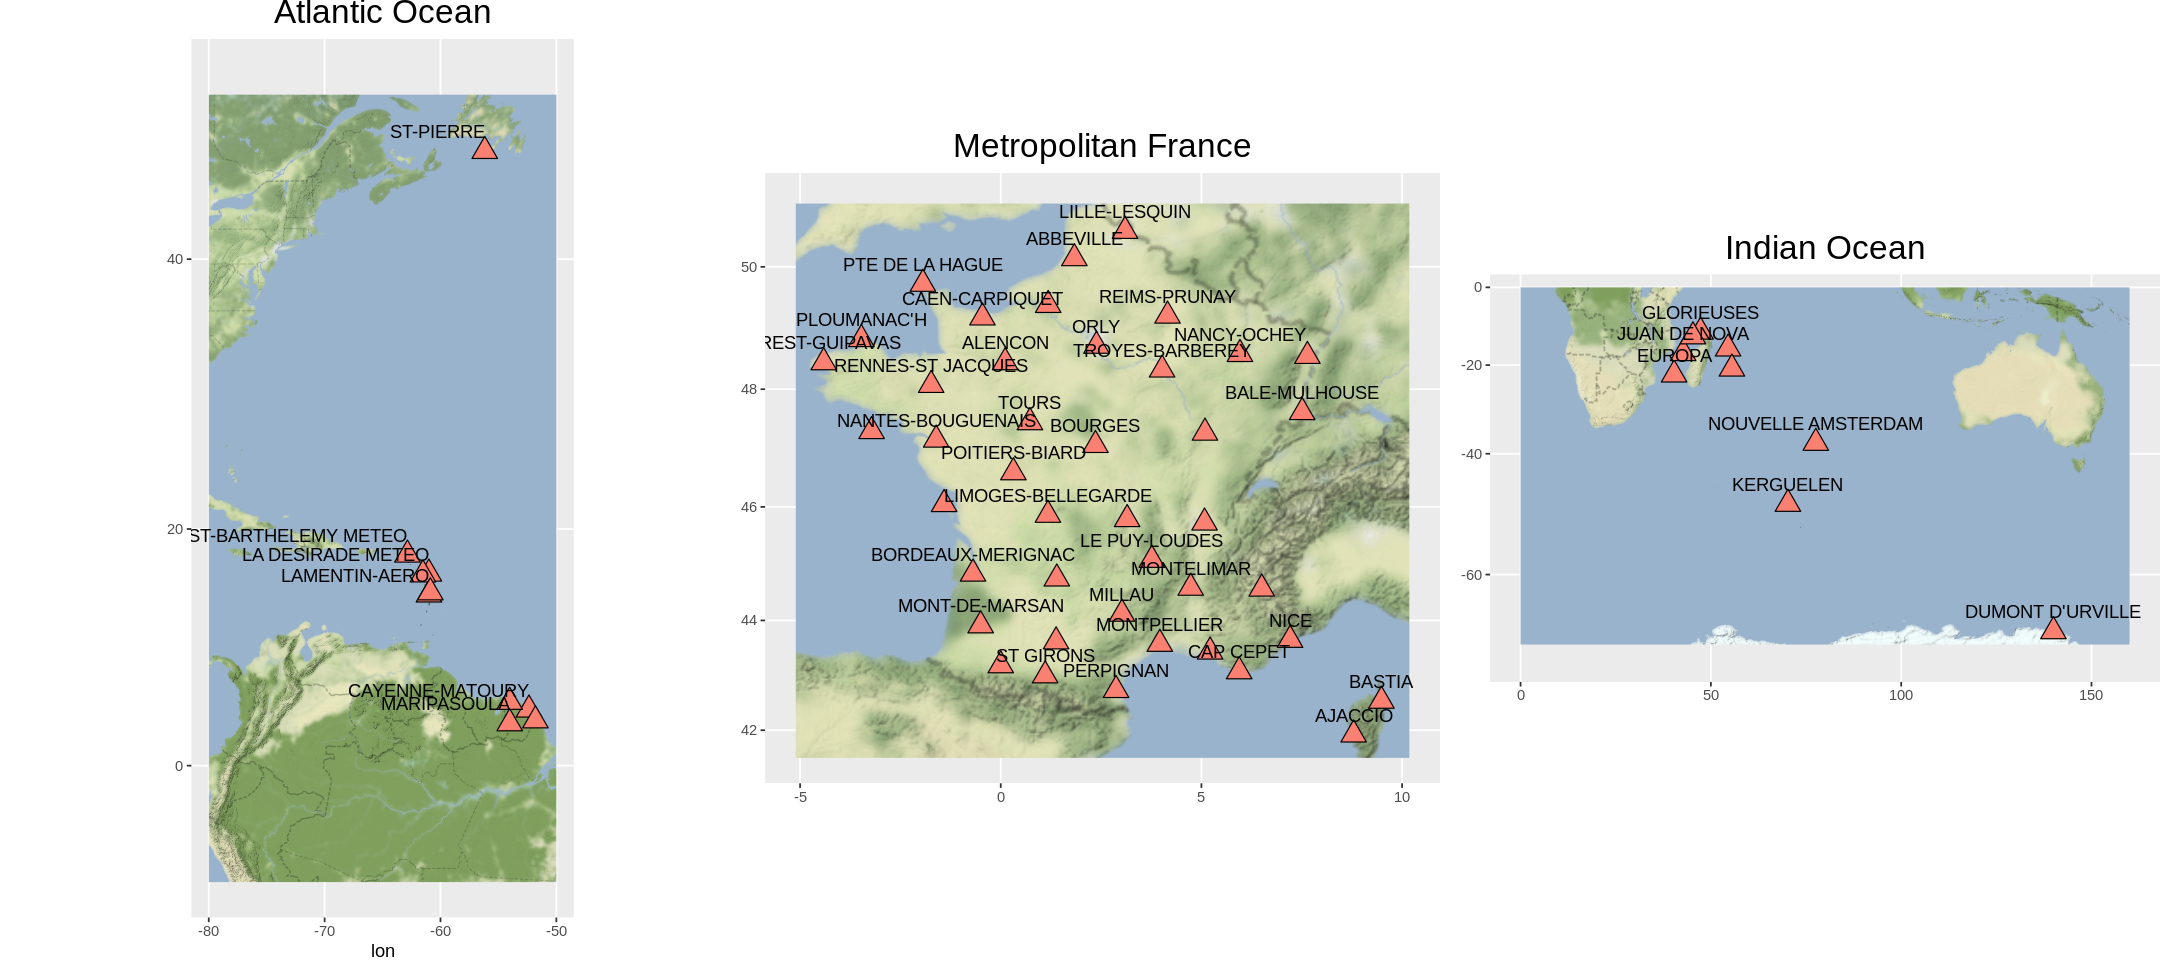

In [17]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)

# this is the most appealing way to output the grid of maps
# however we coud not find a way to render it into HTML 
# saving it on Github

#grid.arrange(grobs=list(atlantic_ocean.map, 
#                        metropole.map,
#                        indian_ocean.map) ,
#layout_matrix = rbind(c(1, 2, 2), 
#                      c(1, 2, 2),
#                      c(NA, 3, 3)) )

# More crude way but working with HTML
grid.arrange(grobs=list(atlantic_ocean.map, 
                        metropole.map,
                        #grid.rect(gp=gpar(col="white")),
                        indian_ocean.map), nrow=1, )


## Plotting Monthly Temperatures

We also can take advantage of the already aggregated temperature data in the WeKG-MF. The developers of the WeKG-MF dataset calculated minimum, maximum and average daily temperatures. 

In [ ]:
station_name <- 'NICE'

In [ ]:
query_monthly_temp <- '
SELECT ?month (AVG(?temp_avg) as ?avg_temp)
              (AVG(?temp_min) as ?min_temp) 
              (AVG(?temp_max) as ?max_temp) 
              ?stationIRI 
              ?stationName
              (GROUP_CONCAT(DISTINCT ?year; SEPARATOR=", ") AS ?years)
WHERE
{
    #VALUES (?year) {("%s"^^xsd:gYear) } # uncomment if only one year is desired
    VALUES (?stationName) {("%s")}
    ?stationIRI rdfs:label ?stationName.

    ?s a qb:Slice ;
      wes-dimension:station ?stationIRI ;
      wes-dimension:year ?year;
      qb:observation [a qb:Observation ;
                      wes-attribute:observationDate ?date ;
                      wes-measure:avgDailyTemperature ?temp_avg; 
                      wes-measure:minDailyTemperature ?temp_min; 
                      wes-measure:maxDailyTemperature ?temp_max] .

    BIND(MONTH(?date) as ?month)
}
GROUP BY ?month ?stationIRI ?stationName
ORDER BY ?month
'
query_monthly_temp <- sprintf(query_monthly_temp, "", station_name)
query_monthly_temp <- paste(sparql_prefix, query_monthly_temp)

res_monthly_temp <- SPARQL(url= endpoint,
                          query = query_monthly_temp,
                          ns=data_prefix,
                          extra=NULL)$results

print(paste('Result rows:', nrow(res_monthly_temp)))

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 5)
options(repr.plot.align = 'center')

ggplot (res_monthly_temp, aes(x=month, ) )+
        
        geom_line(size=1 , aes(y=max_temp) , color="darkred") +    
        geom_point(size=2 , aes(y=max_temp) , color="darkred") +    
        geom_text(aes(y=max_temp +1, label = round(max_temp, 1)),  vjust = 0, hjust = 0, size=5) +

        geom_line(size=2 , aes(y=min_temp) , color="navy") +    
        geom_point(size=3 , aes(y=min_temp) , color="navy") +    
        geom_text(aes(y=min_temp +1, label = round(min_temp, 1)),  vjust = 0, hjust = 0, size=5) +
        
        theme_minimal() +
        theme(text = element_text(size=20)) +
        ggtitle(sprintf("Average monthly temperatures in %s\nover %s", station_name , res_monthly_temp[1, 'years' ]) ) +
        ylab("Temperature (C°)")  +
        xlab("") +
        scale_x_continuous(breaks = res_monthly_temp$month,
                           labels=  month.abb[res_monthly_temp$month] ) +
        scale_colour_manual(name = "", values = c("high" = "darkred", "low" = "navy"))
        

TODO: 
- improve legend
- add interval band


## Are the temperatures rising?


In [ ]:
station_name <- "NICE"

In [ ]:
query_daily_temp <- '
SELECT ?station ?stationName 
       ?date 
       ?temp_avg
       ?temp_min  
       ?temp_max  

WHERE
{
  VALUES (?stationName) {("%s") }
  ?station rdfs:label ?stationName.

  ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
           wes-attribute:observationDate ?date ;
           wes-measure:avgDailyTemperature ?temp_avg; 
           wes-measure:minDailyTemperature ?temp_min; 
           wes-measure:maxDailyTemperature ?temp_max] .

  # uncomment if percipitation data is needed      
  #     ?obs a weo:MeteorologicalObservation;
  #            sosa:observedProperty wevp:precipitationAmount;
  #            sosa:hasSimpleResult ?vp;
  #            sosa:phenomenonTime [ a weo:Interval3h ];
  #            sosa:resultTime ?datetime;
  #            wep:madeByStation ?station. 
  #      FILTER  ( xsd:date(SUBSTR(STR(?datetime), 1,10)) =  ?date) 

}

GROUP BY ?station ?stationName ?date
ORDER BY ?date
'
query_daily_temp <- sprintf(query_daily_temp, station_name)
query_daily_temp <- paste(sparql_prefix, query_daily_temp)

res_daily_temp <- SPARQL(url= endpoint,
              query = query_daily_temp,
              ns=data_prefix,
              extra=c("timeout=300000"))$results

print(paste('Result rows:', nrow(res_daily_temp)))

### Convert data frame to a Time Series object
A time series is "a set of data collected sequentially usually at fixed intervals of time" (Merriam-Webster 2021). Time series data has characteristics that make it very useful for analyzing phenomena that change over time.

In [ ]:
# convert date from numeric representation returned from query to R's date format
res_daily_temp$date <- as.POSIXct(res_daily_temp$date, origin="1970-01-01")

# convert to time series format
historical <- xts(res_daily_temp[,c("temp_max","temp_min", "temp_avg")], 
                  order.by=as.Date(res_daily_temp$date))

# fill in missing values (there is no missing data in the WeKG temperatures,
# but this code is useful nevertheless)
historical <- tsbox::ts_regular(historical)
historical <- na.fill(historical, "extend")

### Plot Time Series

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 5)
options(repr.plot.align = 'center')

plot(ts_ts(historical$temp_max), col="darkred", 
     bty="n", las=1, fg=NA, 
	   ylim=c(-20, 40), 
		 ylab="Temperature (C°)",
		 xlab="")

lines(ts_ts(historical$temp_min), col="navy")

grid(nx=NA, ny=NULL, lty=1, col="gray")

legend("topright", fill=c("darkred", "navy"), cex=1.0,
	                 legend=c("high", "low"), bg="white")

title(sprintf("High and low temperatures in %s for a period from %s to %s" ,
               station_name, start(historical), end(historical)))

summary(historical)

### Time Series Decomposition
Time series decomposition separate a time series into three fundamental components that can be added together to create the original data:

- a seasonal component
- a long-term trend component
- a random component

When using historical data to anticipate what might happen in the future, we often wish to separates the seasonal and random components to see the long term historical trends.

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 5)

decomposition_max <- stl(ts_ts(historical$temp_max), s.window=365, t.window=2901)
decomp_plt_max <-  plot(decomposition_max, col="darkred") #autoplot(decomposition_max, range.bars = TRUE) 
print("High temperatures trend summary")
summary(decomposition_max$time.series[,"trend"])
title("High temperatures decomposition")


decomposition_min <- stl(ts_ts(historical$temp_min), s.window=365, t.window=2901)
decomp_plt_min <-  plot(decomposition_min, col="navy")#autoplot(decomposition_min, range.bars = TRUE)
print("Low temperatures trend summary")
summary(decomposition_min$time.series[,"trend"])
title("Low temperatures decomposition")

OBSERVATIONS AND CONCLUSIONS


---

- we can see the rising trend for both high and low temperatures at least until 2019

### Predicting monthly temperatures with Holt-Winters forecast
To forecast future temperatures based on historical observations, we can use [Holt-Winters](https://otexts.com/fpp2/holt-winters.html) model that considers past seasonal cycles, trends, and random variation.

- We first create training data consisting of a time series of high temperatures aggregated by month. (Monthly data is used instead of daily data because the hw() modeling function will throw a "Frequency too high" error on daily data.)
- The parameters to the hw() modeling function are the time series and the number of additional observations to forecast. h=12 indicates modeling one year into the future.
- We calculate the test accuracy of the model after re-fitting on the training data only. 

It is a quick method but it only using seasonal and trend components.

In [ ]:
ts.data <- apply.monthly(historical$temp_max, max)
# apply.monthly takes the last day of the observations as an index
# but we need a first one. The next command does just that.
index(ts.data) <- seq(start(historical), by="month", length=length(ts.data))
ts.data <- ts_ts(ts.data)

training.data <- head(ts.data, 60)
test.data <- tail(ts.data, 12)

training.data
test.data

In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 5)
options(repr.plot.align = 'center')

model.tmax <- hw(training.data, h=12)

# two-liner!
plot(model.tmax, lwd=3, bty="n", las=1,PI=TRUE)
grid(nx=NA, ny=NULL, lty=1)

# ggplot - many lines, more control
#autoplot(training.data, color="darkred", lwd=1) +
#         autolayer(test.data, color="grey" , lwd=1) +
#         autolayer(model.tmax, PI=FALSE, color="purple" , lwd=1) +
#         theme_minimal() +
#         theme(text = element_text(size=16)) +
#         ylab("Monthly High Temperature (C°)") +
#         ggtitle(model.tmax$method)

In [ ]:
accuracy(model.tmax$mean, test.data)

OBSERVATIONS AND CONCLUSIONS:

---

The model forecast's MSPE (Mean Absolute Percentage Error) is ~7%. Not too bad. 

### Predicting daily temperatures with ARIMA forecast

Auto regressive integrated moving average (ARIMA) modeling involves a detailed analysis of the training data using lags and lagged forecast errors. https://otexts.com/fpp2/arima.html.

- The first step is to use a function like auto.arima() to analyze the data and find appropriate model configuration parameters. 

- The second step is to use the parameters at the top of the auto.arima()  listing to pass to the arima() function as the order and seasonal parameters to create a model.

- The third step is to create a forecast with the forecast() function.

NOTE: running _auto.arima_ and training _arima_ model on this 5-year daily dataset may take more than 15 min each on Google Colab virtual machine. It would be beneficial to save the models after the training. 

NOTE: If you are running this notebook in Google Colab, saved models as in the code below will persist only for the duration of the Colab session. Saving the models on Google Drive is tricky and currently outside of the scope of this demo. You can find some hints on how to do it here: https://towardsdatascience.com/access-google-drive-using-google-colab-running-an-r-kernel-3736db7835 .

In [ ]:
# Step 1
auto_arima.file.name <- "auto_arima_params.RData"

# if you need find a new ARIMA parameters
# uncomment the line below
#file.remove(auto_arima.file.name)

ts.data <- ts_ts(historical$temp_max)

training.data <- head(ts.data, length(historical$temp_max) - 365)
test.data <- tail(ts.data, 365)

if (!file.exists(auto_arima.file.name)) {
  parameters_max <- auto.arima(training.data)
  save(parameters_max, file = auto_arima.file.name )
}
else {load(file = auto_arima.file.name)}

print(parameters_max)

In [ ]:
# Step 2
arima_model.file.name <- "arima_model.RData"

# if you need retrain ARIMA model
# uncomment the line below
#file.remove(auto_model.file.name)

if (!file.exists(arima_model.file.name)) {
  arima.model <- arima(training.data, order = c(1,0,2), 
                       seasonal = list(order=c(0,1,0), period=365))

  save(arima.model, file = arima_model.file.name )
} else {load(file = "arima_model.RData")}

In [ ]:
# Step 3
arima.max <- forecast(arima.model, 365)

print("ARIMA model quality metrics")
accuracy(arima.max, test.data)

# 2 liner
plot(arima.max, lwd=3, bty="n", las=1, fg=NA, 
	xlim=c(2016, 2023), ylab="Daily High Temperature (C°)")

grid(nx=NA, ny=NULL, lty=1)

# ggplot -  many lines, more control
#autoplot(training.data, color="darkred", lwd=1) +
#         autolayer(test.data, color="grey" , lwd=1) +
#         autolayer(arima.max, PI=FALSE, color="purple" , lwd=1) +
#         theme_minimal() +
#         theme(text = element_text(size=16)) +
#         ylab("Daily High Temperature (C°)") +
#         ggtitle(paste("Forecast from ", arima.max$method))

### Compare today's weather with ARIMA forecast

In [ ]:
day_forecast <- function(date, predictions) { 
    
    # do this so the date can be of any type
    date <- as.Date(date)
    
    day_index <- difftime(date, as.Date("2020-12-31"), units = "days")

    lo <- lapply(predictions$lower[day_index,], round, 2)
    up <- lapply(predictions$upper[day_index,], round, 2)
    names(lo) <- NULL
    names(up) <- NULL      

    delta80 <- (up[[1]] - lo[[1]]) / 2
    delta95 <- (up[[2]] - lo[[2]]) / 2 
     
    return ( list(mean = round(predictions$mean[day_index],2) ,
                  interval_80= c(lo[[1]], up[[1]] ),
                  delta_80 = delta80 ,
                  interval_90= c(lo[[2]], up[[2]] ),
                  delta_95 = delta95) )
}

#today_forecast <- day_forecast(Sys.Date(), arima.max)

# random day from the test set


display_html(sprintf('<strong style="color:darkred;font-size:20px">The forecast for hight temperature today %s is: %.02f ± %.02f C° with 80%% certainty</strong>',
                    format(Sys.Date(), format="%d/%m/%Y"), 
                    today_forecast$mean,
                    today_forecast$delta_95))

We have options to obtain actual forecast:
- open https://meteofrance.com/previsions-meteo-france/nice/06000 website
- embed Meteo France https://meteofrance.com/widgets free widget (it does not show min/max temperatures tho)
- embed https://weatherwidget.io/ widget
- embed Meteo Blue https://www.meteoblue.com/en/weather/widget/setupday widget 
- try https://open-meteo.com/en api

All options require either mapping of the stations to a widget url active editing.

In [ ]:
meteo.france.widget <- '
<iframe id="widget_autocomplete_preview"  width="600" height="150" frameborder="0" 
        src="https://meteofrance.com/widget/prevision/060880"> </iframe>'

display_html(meteo.france.widget)

In [ ]:
weatherwidget.io <- '
<a class="weatherwidget-io" href="https://forecast7.com/en/43d717d26/nice/" 
                            data-label_1="NICE" data-label_2="WEATHER" 
                            data-theme="clear" data-days="3" />
<script>
!function(d,s,id)
    {var js,fjs=d.getElementsByTagName(s)[0];
    if(!d.getElementById(id)){
      js=d.createElement(s);
      js.id=id;
      js.src="https://weatherwidget.io/js/widget.min.js";
      fjs.parentNode.insertBefore(js,fjs);}
      }
      (document,"script","weatherwidget-io-js");
</script>'

display_html(weatherwidget.io )


In [ ]:
meteo.blue.widget <- '
<iframe src="https://www.meteoblue.com/en/weather/widget/daily/nice_france_2990440?geoloc=fixed&days=4&tempunit=CELSIUS&windunit=KILOMETER_PER_HOUR&precipunit=MILLIMETER&coloured=coloured&pictoicon=0&pictoicon=1&maxtemperature=0&maxtemperature=1&mintemperature=0&mintemperature=1&windspeed=0&windgust=0&winddirection=0&uv=0&humidity=0&precipitation=0&precipitation=1&precipitationprobability=0&precipitationprobability=1&spot=0&pressure=0&layout=light"  frameborder="0" scrolling="NO" allowtransparency="true" sandbox="allow-same-origin allow-scripts allow-popups allow-popups-to-escape-sandbox" style="width: 416px; height: 420px"></iframe><div><!-- DO NOT REMOVE THIS LINK --><a href="https://www.meteoblue.com/en/weather/week/nice_france_2990440?utm_source=weather_widget&utm_medium=linkus&utm_content=daily&utm_campaign=Weather%2BWidget" target="_blank" rel="noopener">meteoblue</a></div>
'

meteo.blue.widget <- '
<iframe src="https://www.meteoblue.com/en/weather/widget/daily/nice_france_2990440?geoloc=fixed&days=4&tempunit=CELSIUS&windunit=KILOMETER_PER_HOUR&precipunit=MILLIMETER&coloured=coloured&pictoicon=0&pictoicon=1&maxtemperature=0&maxtemperature=1&mintemperature=0&mintemperature=1&windspeed=0&windgust=0&winddirection=0&uv=0&humidity=0&precipitation=0&precipitation=1&precipitationprobability=0&precipitationprobability=1&spot=0&pressure=0&layout=light"
  frameborder="0" scrolling="NO" allowtransparency="true" 
  sandbox="allow-same-origin allow-scripts allow-popups allow-popups-to-escape-sandbox" 
  style="width: 600px; height: 340px"></iframe>
  <div><!-- DO NOT REMOVE THIS LINK -->
  <a href="https://www.meteoblue.com/en/weather/week/nice_france_2990440?utm_source=weather_widget&utm_medium=linkus&utm_content=daily&utm_campaign=Weather%2BWidget" 
     target="_blank" rel="noopener">meteoblue</a></div>
'
display_html(meteo.blue.widget)

## Future work

### Deep Learning Weather prediction

https://blogs.rstudio.com/ai/posts/2020-09-01-weather-prediction/

https://colab.research.google.com/drive/1URSjWfcnhgesHWCqd7Un5GHECYblY04r?usp=sharing

